In [1]:
import xarray as xr
import numpy as np
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scipy.signal as signal
import scipy.stats as stats

# Set up

### Data Processing

In [2]:
# def read_cesmLE(variable, time):
#     """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

#     arrays = []
#     decades = ['185001-185912','186001-186912','187001-187912','188001-188912','189001-189912',
#                '190001-190912','191001-191912','192001-192912','193001-193912','194001-194912',
#                '195001-195912','196001-196912','197001-197912','198001-198912','199001-199912',
#                '200001-200912','201001-201412','201501-202412','202501-203412','203501-204412',
#                '204501-205412','205501-206412','206501-207412','207501-208412','208501-209412',
#                '209501-210012']
#     for d in decades:
#         files = sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time+'_1/'+variable+'/b.e21.*[0-9]*.{}.nc'.format(d)))
#         # print(len(files))
#         array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member')

#         arrays.append(array_group)

#     final_array = xr.concat(arrays, dim = 'time')

#     return final_array

# def read_cesmLE_daily(variable, time):
#     """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

#     arrays = []
#     decades = ['18500101-18600101','18600102-18700101','18700102-18800101','18800102-18900101','18900102-19000101',
#                '19000102-19100101','19100102-19200101','19200102-19300101','19300102-19400101','19400102-19500101',
#                '19500102-19600101','19600102-19700101','19700102-19800101','19800102-19900101','19900102-20000101',
#                '20000102-20100101','20100102-20141231','20150101-20250101','20250102-20350101','20350102-20450101',
#                '20450102-20550101','20550102-20650101','20650102-20750101','20750102-20850101','20850102-20950101',
#                '20950102-21001231']
#     for d in decades:
#         files = sorted(glob.glob('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time+'_1/'+variable+'/b.e21.*[0-9]*.{}.nc'.format(d)))
#         # print(len(files))
#         array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member')

#         arrays.append(array_group)

#     final_array = xr.concat(arrays, dim = 'time')

#     return final_array

def read_cesmLE_daily(variable, time_int):
    """ Read in CESM2 Large ensemble data. Returns an array that is ensemble member x time x space"""

    # tag = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.BHIST*[0-9]*.nc'#.format(d)
    tag = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/ice/proc/tseries/'+time_int+'_1/'+variable+'/b.e21.BHISTcmip6.f09_g17.LE2-1001*[0-9]*.nc'

    files = sorted(glob.glob(tag))
    final_array = xr.open_mfdataset(files)
    # array_group = xr.open_mfdataset(files, combine='nested', concat_dim='member',parallel=True)
    # final_array = array_group.mean(dim='member')

    # final_array = xr.open_dataset(file)

    return final_array

### Plotting

In [3]:
def convert_coords(lat, lon, og_data, ccrs_grid):
    """ convert data to appropriate coordinates for ccrs plot """
    
    grid = ccrs_grid
    coords = grid.transform_points(ccrs.PlateCarree(), 
                                   np.array(lon), 
                                   np.array(lat))
    
    xs = np.ma.masked_invalid(coords[..., 0])
    ys = np.ma.masked_invalid(coords[..., 1])
    data = np.ma.masked_invalid(og_data)
    data.mask = np.logical_or(data.mask, xs.mask, ys.mask)
    
    xs = xs.filled(0)
    ys = ys.filled(0)
    
    return xs,ys,data

def fashion_space(ax):
    """ set standard design paramaters for hemispheric stereo plots """
    
    ax.set_extent([-180,180,55,90], ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND,facecolor = 'gainsboro', zorder=6)
    ax.gridlines()
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = matplotlib.path.Path(verts * radius + center)
    
    ax.set_boundary(circle, transform=ax.transAxes)
    
def plot_nps(data_array, bounds, cmap):
    """ plot a NorthPolarStereo map """
    
    data = data_array
    lat = data_array.TLAT
    lon = data_array.TLON
    nps = ccrs.NorthPolarStereo()
    
    xs,ys,plot_data=convert_coords(lat, lon, data, nps)
    
    # fig = plt.figure(figsize = (6,6))
    ax = plt.gca() #axes(projection=nps)
    fashion_space(ax)
    # cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(bounds[0], bounds[1], 6)
    clevs = np.linspace(bounds[0], bounds[1], 16)
    img = ax.contourf(xs, ys, data,clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'both')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

### Methods

In [4]:
def butterworth(data, nints, filt_type):
    nyquist = 1/2

    if filt_type == 'lowpass':
        cutoff = 1/nints*1/nyquist
        sos = signal.butter(5, cutoff, 'lp', output='sos')
    elif filt_type == 'bandpass':
        high_cutoff = 1/nints[0]*1/nyquist
        low_cutoff = 1/nints[1]*1/nyquist
        sos = signal.butter(5, low_cutoff, high_cutoff, 'bp', output='sos')
    elif filt_type == 'highpass':
        cutoff = 1/nints*1/nyquist
        sos = signal.butter(5, cutoff, 'hp', output='sos')
    else:
        print('filter type not valid!')

    new_data = signal.sosfilt(sos, anoms)

    return new_data


def detrend_data(data):

    results = data.polyfit(dim='time', deg=1)
    new_data = data - xr.polyval(data.time, results.polyfit_coefficients)

    # new_data = butterworth(anoms, len(anoms.time), 'highpass')

    da = xr.DataArray(new_data,
                      coords=data.coords,
                      dims=data.dims,
                      attrs=data.attrs
                      )
    return da


def get_monthly_anomalies(data):
    
    new_data = detrend_data(data)

    climat = new_data.groupby('time.month').mean(dim='time')
    anoms = new_data.groupby('time.month') - climat
    

    # anoms = new_data

#     anoms = data
#     results = anoms.polyfit(dim='time', deg=1)
#     new_data = anoms - xr.polyval(anoms.time, results.polyfit_coefficients)

#     # new_data = butterworth(anoms, len(anoms.time), 'highpass')

#     da = xr.DataArray(new_data,
#                       coords=anoms.coords,
#                       dims=anoms.dims,
#                       attrs=anoms.attrs
#                       )
    return anoms


def get_daily_anomalies(data):
    
    new_data = detrend_data(data)
    
    climat = new_data.groupby('time.dayofyear').mean(dim='time')
    anoms = new_data.groupby('time.dayofyear') - climat

    return anoms


def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """ Input: Two xr.Datarrays of any dimensions with the first dim being time. 
        Thus the input data could be a 1D time series, or for example, have three 
        dimensions (time,lat,lon). 
        Datasets can be provided in any order, but note that the regression slope 
        and intercept will be calculated for y with respect to x.
        Output: Covariance, correlation, regression slope and intercept, p-value, 
        and standard error on regression between the two datasets along their 
        aligned time dimension.  
        Lag values can be assigned to either of the data, with lagx shifting x, and
        lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:

        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid 
        # (nan). Hence it needs to be dropped
        # x   = x.shift(time = -lagx) #.dropna(dim='time')
        x   = x.shift(time = -lagx) #.dropna(dim='time')
    
        # Next important step is to re-align the two datasets so that y adjusts
        # to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        # y   = y.shift(time = -lagy)#.dropna(dim='time')
        y   = y.shift(time = -lagy) #.dropna(dim='time')
        x,y = xr.align(x,y)

    #3. Compute data length, mean and standard deviation along time axis: 
    n = y.notnull().sum(dim='time')
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)

    #4. Compute covariance along time axis
    cov =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)

    #5. Compute correlation along time axis
    cor = cov/(xstd*ystd)

    return cov, cor

def define_markov(deseasonalized, lag):
    """ Expresses the evolution of a timeseries's detrended and deasonalized anomalies 
        as a Markov process with some lagged autocorrelation (or persistence) and some 
        projected external forcing. 

        Returns the anomalies of the timeseries (h_prime), the lagged autocorrelation
        (autocorrelation), and the external forcing projection's contribution to the 
        total anomaly at each timestep (external).

        Input: a timeseries (1-3 dimensional) in the form of an xarray.DataArray
        Ouputs: h_prime, autocorrelation, and external in the form of xarray.DataArrays
    """

    null, A = lag_linregress_3D(deseasonalized, deseasonalized, lagx=0, lagy=lag-1)
    autocorrelation = A#[1]

    # get day_1 and day_n-1
    h_prime = deseasonalized[1:,:,:]
    h_prime_nm1 = deseasonalized[0:-1,:,:]

    # calculate external contributions
    external = h_prime - autocorrelation*h_prime_nm1

    return h_prime, autocorrelation, external


def markov_2(deseasonalized, lag, delt):

    null, A = lag_linregress_3D(deseasonalized, deseasonalized, lagx=0, lagy=lag-1)
    autocorrelation = A

    h_prime = deseasonalized[1:, :, :]
    h_prime_nm1 = deseasonalized[0:-1, :, :]

    r = -1 * np.log(autocorrelation)

    external = (h_prime - (1 - r*delt)*h_prime_nm1)/delt

    return h_prime, autocorrelation, r, external

def markov_variance(h_prime, autocorrelation, external):
    """ Calculate the total variance of a timeseries, and that of each of it's Markov
        components. Return each variance as an xr.DataArray object.

        Inputs:
        Outputs: variance in xr.DataArray; ratio of variance (approximation and calculated)
    """

    # calculate total variance
    total_squared = h_prime**2
    temp = 1/(len(total_squared)-1) * total_squared.sum(dim = 'time', skipna = True)
    variance = temp.where(temp > 0)

    # calculate external variance
    ext_squared = external**2
    ext_temp = 1/(len(ext_squared)-1) * ext_squared.sum(dim = 'time', skipna=True)
    ext_variance = ext_temp.where(ext_temp > 0)

    # assume difference is related to persistence
    pst = h_prime - external
    pst_squared = pst**2
    pst_temp = 1/(len(pst_squared)-1) * pst_squared.sum(dim = 'time', skipna=True)
    pst_variance = pst_temp.where(pst_temp > 0)

    # calculate the ratio of external variance to the persistence approximation
    ratio_approx = ext_variance/(1-autocorrelation)

    # calculate the ratio of external variance to persistence variance
    ratio_straight = ext_variance/pst_variance

    return variance, pst_variance, ext_variance, ratio_approx, ratio_straight

# Monthly Analysis

In [5]:
cesmle_thickness = read_cesmLE_daily('hi', 'month')

In [6]:
data = cesmle_thickness.hi
data = data.where(data > 0.005).compute()

In [10]:
anomalies = data.groupby('time.year').mean(dim='time') - data.groupby('time.year').mean(dim='time').mean(dim='year')

### Annual

In [49]:
def difference(dataset, interval=1):
    """ Calculate the difference between two timesteps of a timeseries at a prescribed 
        interval.
        
        Inputs: xr.DataArray or xr.DataSet timeseries
        Output: differenced array as an xr.DataArray
    """
    
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    
    diff_array = xr.DataArray(diff,
                              coords=dataset.isel(time = slice(0,-1*interval)).coords, 
                              dims=dataset.isel(time = slice(0,-1*interval)).dims, 
                              attrs=dataset.isel(time = slice(0,-1*interval)).attrs
                             )
    return diff_array

In [50]:
dt_data = difference(data, interval=12)

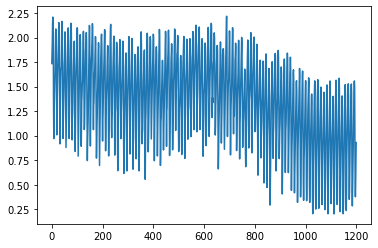

In [61]:
plt.plot(data[:,375,95] - dt_data[:, 375, 95])

In [55]:
dt_dt_stdev = dt_data.std(dim='time')

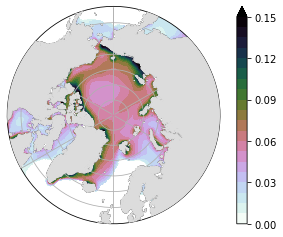

In [60]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(dt_dt_stdev.TLAT, dt_dt_stdev.TLON, dt_dt_stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.15, 6)
clevs = np.linspace(0, 0.15, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [22]:
detrended = detrend_data(data)
anomalies = get_monthly_anomalies(data)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


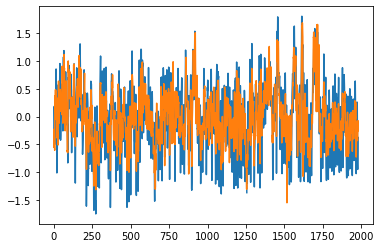

In [23]:
plt.plot(detrended[:,375,95])
plt.plot(anomalies[:,375,95])

In [11]:
dt_stdev = detrended.std(dim='time')
an_stdev = anomalies.std(dim='time')

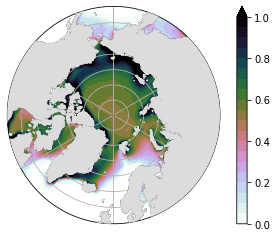

In [12]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(dt_stdev.TLAT, dt_stdev.TLON, dt_stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 1, 6)
clevs = np.linspace(0, 1, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

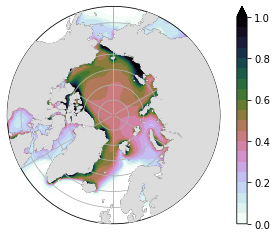

In [17]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(an_stdev.TLAT, an_stdev.TLON, an_stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 1, 6)
clevs = np.linspace(0, 1, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [15]:
anomalies = anomalies.rename({'year':'time'})

In [16]:
# h_prime, auto, external = define_markov(anomalies, 2)
h_prime, auto, damp, external = markov_2(anomalies, 2, 1)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [17]:
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

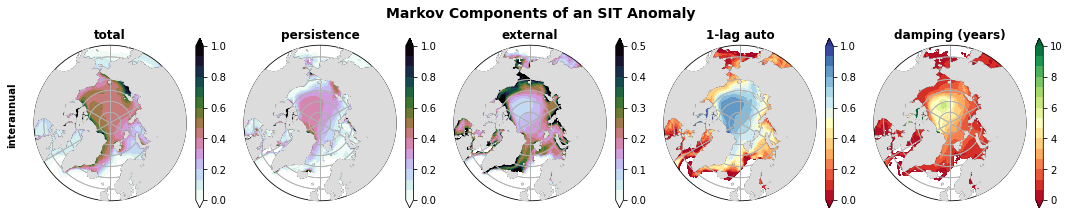

In [21]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(1/damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'interannual', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

### Seasonal

In [24]:
DJF = anomalies.groupby('time.season')['DJF']
MAM = anomalies.groupby('time.season')['MAM']
JJA = anomalies.groupby('time.season')['JJA']
SON = anomalies.groupby('time.season')['SON']

#### DJF

In [25]:
h_prime, auto, damp, external = markov_2(DJF, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


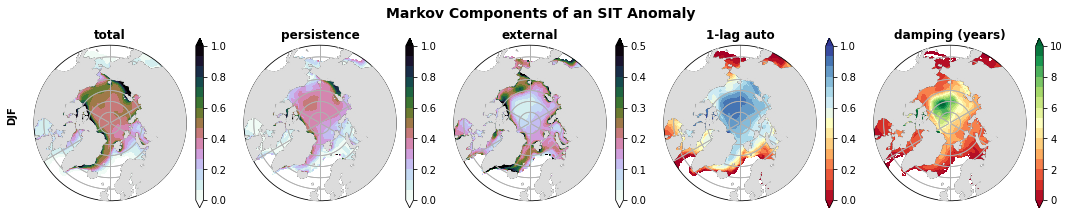

In [60]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(1/damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'DJF', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

#### MAM

In [67]:
h_prime, auto, damp, external = markov_2(MAM, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


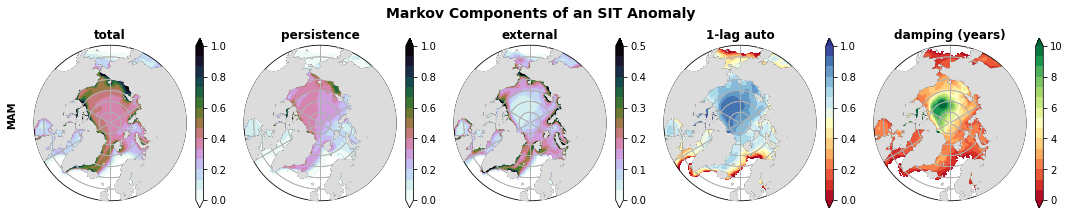

In [68]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(1/damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'MAM', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

#### JJA

In [70]:
h_prime, auto, damp, external = markov_2(JJA, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


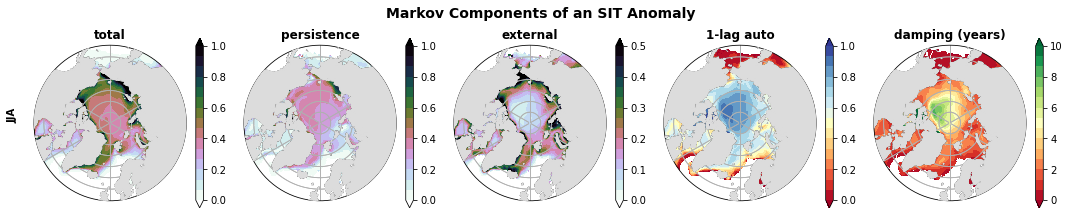

In [71]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(1/damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'JJA', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

#### SON

In [72]:
h_prime, auto, damp, external = markov_2(SON, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


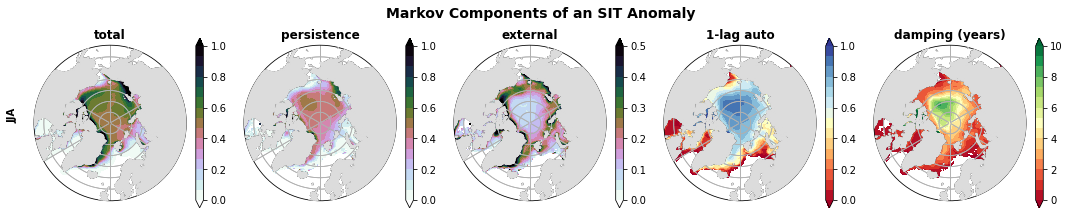

In [73]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')
        
fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)
    
fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)
    
fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(1/damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'JJA', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

# Daily Analysis

In [74]:
cesmle_thickness = read_cesmLE_daily('hi_d', 'day')

In [75]:
data = cesmle_thickness.hi_d
data = data.where(data > 0.005).compute()

In [ ]:
detrended = detrend_data(data)
anomalies = get_daily_anomalies(data)

/glade/u/home/mollyw/.local/lib/python3.7/site-packages/xarray/core/nputils.py:166: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


In [ ]:
plt.plot(detrended[:,375,95])
plt.plot(anomalies[:,375,95])

In [11]:
dt_stdev = detrended.std(dim='time')
an_stdev = anomalies.std(dim='time')

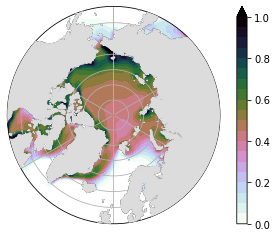

In [12]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(dt_stdev.TLAT, dt_stdev.TLON, dt_stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 1, 6)
clevs = np.linspace(0, 1, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

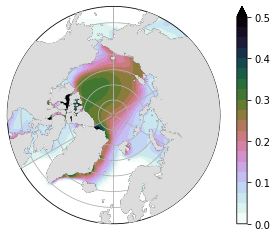

In [15]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(an_stdev.TLAT, an_stdev.TLON, an_stdev, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 0.5, 6)
clevs = np.linspace(0, 0.5, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

In [ ]:
# h_prime, auto, external = define_markov(anomalies, 2)
h_prime, auto, damp, external = markov_2(anomalies, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

In [ ]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (days)', fontweight = 'bold')

fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.gist_heat_r)

fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.gist_heat_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)

fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(damp, bounds = [0, 3*365], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'daily', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

In [ ]:
DJF = anomalies.groupby('time.season')['DJF']
MAM = anomalies.groupby('time.season')['MAM']
JJA = anomalies.groupby('time.season')['JJA']
SON = anomalies.groupby('time.season')['SON']

In [ ]:
h_prime, auto, damp, external = markov_2(DJF, 2, 1)
total_variance, persistence_variance, ext_variance, ratio_approx, ratio_calc = markov_variance(h_prime, auto, external)

In [ ]:
upper = 1
fig, axes = plt.subplots(nrows = 1, ncols = 5, 
                         figsize = (15,3),
                         subplot_kw={'projection': ccrs.NorthPolarStereo()})

axes[0].set_title('total', fontweight = 'bold')
axes[1].set_title('persistence', fontweight = 'bold')
axes[2].set_title('external', fontweight = 'bold')
# axes[3].set_title(r'$\mathbf{\sigma^2_z/1-A}$', fontweight= 'bold')
axes[3].set_title('1-lag auto', fontweight = 'bold')
axes[4].set_title('damping (years)', fontweight = 'bold')

fashion_space(axes[0])
plt.sca(axes[0])
plot_nps(np.sqrt(total_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)

fashion_space(axes[1])
plt.sca(axes[1])
plot_nps(np.sqrt(persistence_variance), bounds = [0, upper], cmap=plt.cm.cubehelix_r)

fashion_space(axes[2])
plt.sca(axes[2])
plot_nps(np.sqrt(ext_variance), bounds = [0, upper/2], cmap=plt.cm.cubehelix_r)

# fashion_space(axes[3])
# plt.sca(axes[3])
# plot_nps(np.sqrt(ratio_approx), bounds = [0, upper], cmap=plt.cm.viridis_r)

fashion_space(axes[3])
plt.sca(axes[3])
plot_nps(auto, bounds = [0, 1], cmap=plt.cm.RdYlBu)

fashion_space(axes[4])
plt.sca(axes[4])
plot_nps(damp, bounds = [0, 10], cmap=plt.cm.RdYlGn)

# axes[count ].set_title(a + ' sampling',fontweight = 'bold')
axes[0].text(-0.11, 0.55, 'daily', weight = 'bold', va='bottom', ha='center', fontsize=10,
             rotation=90, rotation_mode='anchor',
             transform=axes[0].transAxes)

plt.suptitle('Markov Components of an SIT Anomaly', fontweight = 'bold', fontsize = 14)
plt.tight_layout()

# Trial and Error

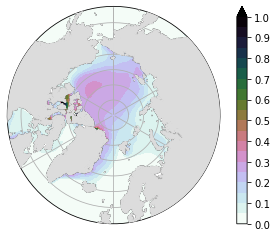

In [102]:
fig = plt.figure()
nps = ccrs.NorthPolarStereo()
ax = plt.axes(projection=nps)
fashion_space(ax)

xs, ys, data_to_plot = convert_coords(blank.TLAT, blank.TLON, blank, ccrs.NorthPolarStereo())
cmap = plt.cm.cubehelix_r
clevs_label = np.linspace(0, 1, 11)
clevs = np.linspace(0, 1, 21)
img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)

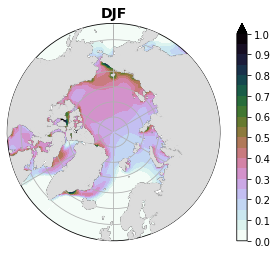

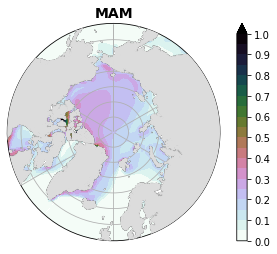

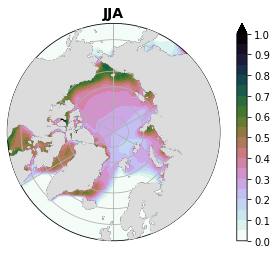

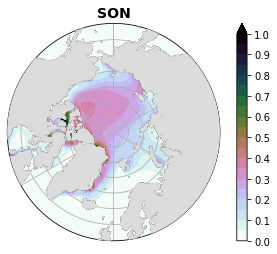

In [103]:
seasons = ['DJF', 'MAM', 'JJA', 'SON']
for s in seasons:
    stdev = anomalies.groupby('time.season')[s].std(dim='time')
    fig = plt.figure()
    nps = ccrs.NorthPolarStereo()
    ax = plt.axes(projection=nps)
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(stdev.TLAT, stdev.TLON, stdev, ccrs.NorthPolarStereo())
    cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(0, 1, 11)
    clevs = np.linspace(0, 1, 21)
    img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    plt.title(s, fontweight='bold', fontsize=14)

In [66]:
seasons = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
STDEV = anomalies.std(dim='time')
for s in range(1, 13):
    stdev = STDEV.groupby('time.month')[s]
    fig = plt.figure()
    nps = ccrs.NorthPolarStereo()
    ax = plt.axes(projection=nps)
    fashion_space(ax)

    xs, ys, data_to_plot = convert_coords(stdev.TLAT, stdev.TLON, stdev, ccrs.NorthPolarStereo())
    cmap = plt.cm.cubehelix_r
    clevs_label = np.linspace(0, 0.5, 11)
    clevs = np.linspace(0, 0.5, 21)
    img = ax.contourf(xs, ys, data_to_plot, clevs, transform=ccrs.NorthPolarStereo(), cmap=cmap, extend = 'max')
    cbar2 = fig.colorbar(img, ax=ax, ticks= clevs_label)
    plt.title(seasons[s-1], fontweight='bold', fontsize=14)

KeyError: 'time'

In [12]:
nyquist = 1/2
cutoff = 1/len(anoms.time) * 1/nyquist
sos = signal.butter(5, cutoff, 'hp', output='sos')

filtered = xr.apply_ufunc(signal.sosfilt, sos, anoms,
               input_core_dims = [[], ['time']],
               output_core_dims = [['time']]) 
# filtered = signal.sosfilt(sos, anoms)

ValueError: dimension time on 1th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single dask array chunk along this dimension, i.e., ``.chunk(time: -1)``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

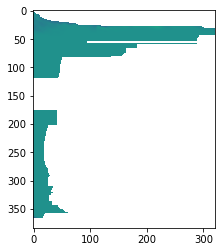

In [61]:
plt.imshow(filtered[-1])

In [22]:
anomalies = get_daily_anomalies(data)

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [ ]:
anomalies.to_netcdf('/glade/u/home/mollyw/Projects/sit_variability/LENS_anomalies.nc')

In [11]:
anomalies

<xarray.DataArray (time: 18250, nj: 384, ni: 320)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-2.23170043e+13, -2.39827650e+13, -2.01277295e+13, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-2.22960139e+13, -2.39601616e+13, -2.01088323e+13, ...,
                     nan,             nan,             nan],
...
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-2.29961770e+06, -2.48973239e+06, -2.14359080e+06, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... nan nan nan nan
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 -79.22 ... nan nan nan nan
    ULON       (nj, ni) float32 321.1 322.2 323.4 324.5 ... nan nan nan nan
    ULAT       (nj, ni) float32 -78.95 -78.95 -78.95 -78.95 ... nan nan nan nan
  * time       (time) object 1965-01-02 00:00:00 ... 2015-01-01 00:00:00
    dayofyear  (time) int64 2 3 4 5 6 7 8 9 10 ... 359 360 361 362 363 364 365 1
Dimensions without coordinates: nj, ni

In [23]:
climat = data.groupby('time.month').mean(dim='time')

KeyboardInterrupt: 

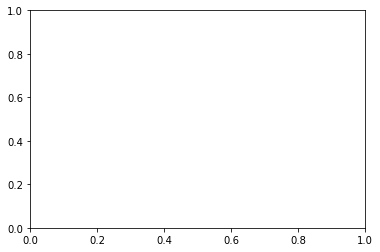

In [9]:
plt.plot(climat[:, 375, 95])

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


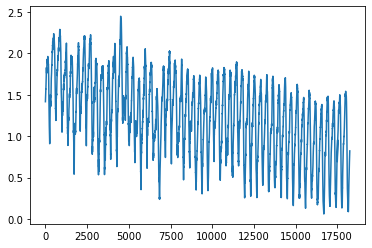

In [18]:
plt.plot(data[:, 375, 95])

In [24]:
anoms = data.groupby('time.month') - climat

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


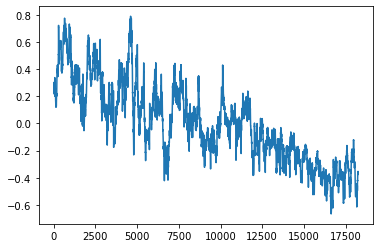

In [21]:
plt.plot(anoms[:,375,95])

In [22]:
new_data = butterworth(anoms, len(anoms.time), 'highpass')

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


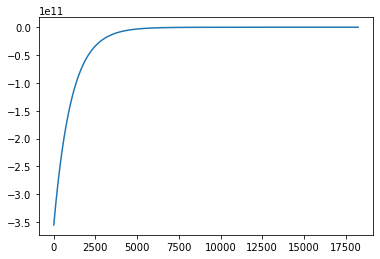

In [23]:
plt.plot(new_data[:,375,95])

In [25]:
fs=1 #1 month (sampling frequency)
nyquist = fs / 2 # 0.5 times the sampling frequency
hi_cutoff = 1/len(anoms.time) * 1/nyquist
# print('low cutoff= ',1/low_cutoff*nyquist,' months') #cutoff=  4.999999999999999  days
print('high cutoff= ',1/hi_cutoff,' months') #cutoff=  4.999999999999999  days
b, a = signal.butter(5, hi_cutoff, btype='high', analog=False) #low pass filter

high cutoff=  990.0  months


In [26]:
day = signal.filtfilt(b, a, anoms[:, 375, 95], axis=0)

/glade/u/home/mollyw/.conda/envs/markov_model/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


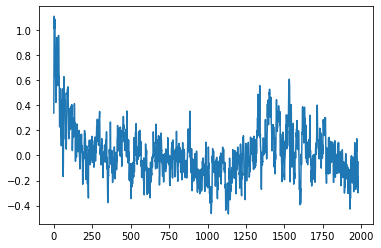

In [27]:
plt.plot(day)

In [48]:
len(anoms.time)

18250